In [1]:
script = False
cluster = False

In [2]:
# general
import numpy as np
from numpy.ma import masked_array
import pandas as pd
import random
import os
import gc

# images & plotting
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# albumentations transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# loading bar
if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

plt.style.use('dark_background')

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Args:
        * seed {int}: number of the seed
    Returns: void
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class Dataset(Dataset):
    """
    PyTorch dataset of images and data
    Args:
        * images {(N, channels, pix, pix) array}: images for dataset
        * data {pandas dataframe}: data for images
        * resize: composed albumentations augmentation to resize images
                  and masks to correct size (96, 96) & tensor
    Returns: Pytorch dataset
    """

    def __init__(self, images, data, resize=None):
        super().__init__()
        self.images = images
        self.data = data
        self.resize = resize

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # get image
        image = self.normalize(img)
        data_point = self.data.iloc[idx].to_dict()  # get data

        # transpose to appropriate dimensions
        image = image.transpose(1, 2, 0)  # (pix, pix, channels)

        # resizing transformation
        if self.resize is not None:
            resized = self.resize(image=image)
            image = resized['image']
        
        # return item
        return {'image': image, 'img': img, 'data': data_point}

    def normalize(self, image):
        """
        Normalize image between 0 and 1 using min and max
        Args:
        * image: (3, pix, pix) numpy array
        Returns: normalized image in original size
        """
        normed = np.empty(image.shape)  # break
        MIN = np.min(image)
        MAX = np.max(image)
        for band in range(3):
            flat = image[band].flatten(order='C')
            for i in range(len(flat)):
                flat[i] = (flat[i]-MIN)/(MAX-MIN)

            normed[band] = np.reshape(flat, image[0].shape, order='C')

        return normed



In [5]:
def show_dataset(dataset, idx):
    """
    Plot training dataset with transformations for visualization
    Args:
        * train_dataset: instance of ImageDataset for training
    Returns: void
    """
    sample = dataset[idx]
    original, transformed = sample['img'], sample['image']

    # set up figure
    fig, ax = plt.subplots(figsize=(8, 4), ncols=2)

    # original image
    orig_rgb = make_lupton_rgb(original[2], original[1], original[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    # transformed image
    new_rgb = make_lupton_rgb(transformed[2], transformed[1], transformed[0], stretch=.5, Q=4.)
    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    if not script:
        plt.show()
        plt.close()

### Make Dataset

In [15]:
# set seeds
seed_everything(9)

# set path name
if cluster:
    path = '/home/gcartwright/Segmentation/Image_Segmentation/' # OSG home
else:
    path = '/Users/gilliancartwright/Desktop/Research/Segmentation/Image-Segmentation/' # local

npos = 21  # number of images TESTING
num_workers = 0  # number of available CPUs
# num_epochs = 8  # number of epochs TESTING
num_classes = 3

# get data from fits file
hdu_list = fits.open(path + 'candidates_complete.fits')
idx = random.sample(range(npos), npos)  # TESTING (using all test data available)
images = hdu_list[1].data[idx, 0:3]  # only want g,r,i bands not z
data = pd.DataFrame(hdu_list[2].data[:][idx])
hdu_list.close()

# check that data was loaded successfully
print(images.shape)

(21, 3, 45, 45)


In [16]:
NUM_PIX = 45  # number of pixels per axis

# Resize transformation
resize_transform = A.Compose([A.Resize(96, 96), ToTensorV2()])

Length of dataset: 21


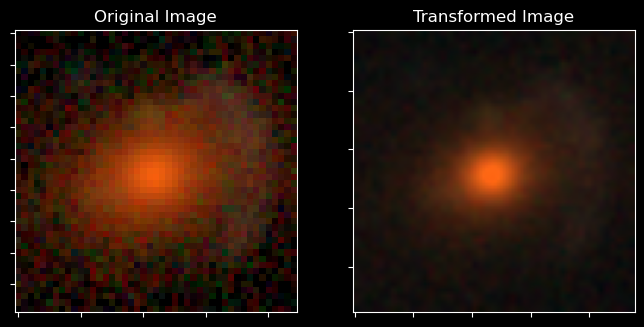

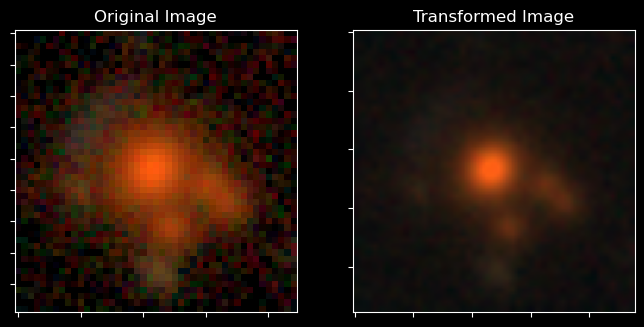

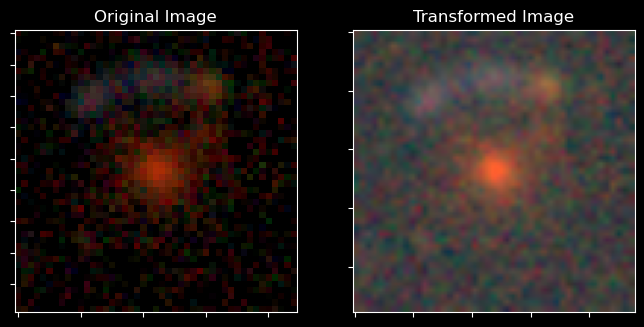

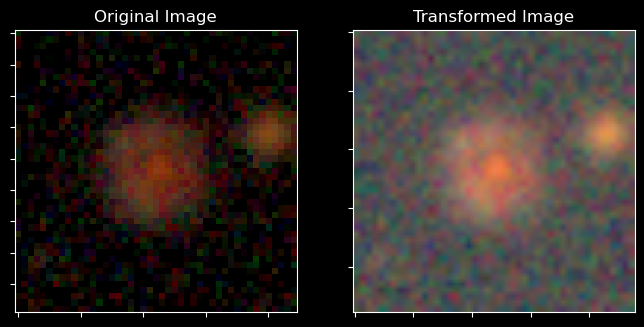

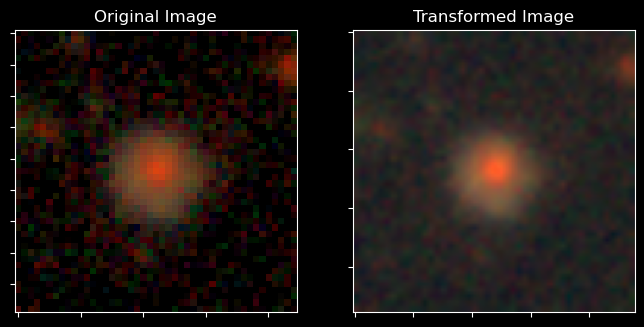

In [17]:
test_dataset = Dataset(images=images, data=data, resize=resize_transform)

# check datasets
print(f'Length of dataset: {len(test_dataset)}')
for i in range(5):
    show_dataset(test_dataset, i)

In [18]:
# set up dataloaders
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,
                                          num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

## Segmentation

### Functions to train the model & visualize results

In [28]:
def make_graphs(image, pred_label):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(8, 4), ncols=2)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[0].imshow(rgb, aspect='equal')
    
    # predicted label
    pred_label = pred_label.detach().numpy()
    ax[1].set_title('Predicted Label')
    ax[1].imshow(pred_label[0, :, :], interpolation='nearest', cmap='magma')  # source
    ax[1].imshow(pred_label[1, :, :], alpha=0.5, interpolation='bilinear', cmap='spring')  # lens
    ax[1].imshow(pred_label[2, :, :], alpha=0.5, interpolation='bilinear', cmap='cool') # noise
    ax[1].axis('off')

    plt.show()

In [33]:
def testing_analysis(accu_lim, test_loader):
    model.double()
    for i_batch, sample in enumerate(tqdm(test_loader)):
#         if(i_batch == 100): break
        sample_image, sample_img = sample['image'], sample['img']

        if device.type == "cuda":
            sample_image = sample_image.cuda()

        output = model(sample_image)
        output = torch.sigmoid(output)

        if(not cluster):
            sample_img = sample_img[0]
            make_graphs(sample_img, output[0])


### Load model and test

In [34]:
class UNet(nn.Module):
    """
    U-Net model
    """
    def __init__(self, classes, pretrained=False): 
        super(UNet, self).__init__()

        if(not cluster):
            self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                                  in_channels=3, classes=classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')

        else:
            self.model = smp.Unet(encoder_name="resnet50", in_channels=3, classes=classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))


    def forward(self, x):
        """
        compute predicted outputs by passing inputs to the model
        """
        x = self.model(x)
        return x


    def pseudo_accuracy(self, output, target):
        """
        get pixel accuracy
        """
        tp, fp, fn, tn = smp.metrics.get_stats(output, target.long(),
                                               mode='multilabel',
                                               threshold=0.5)
        return smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")


    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        """
        train the model
        """
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):
            data = sample['image']
            target = sample['label'].permute(0, 3, 1, 2)  # reshape to match data
            sample_img = sample['img']
            
            sample_data = sample['data']

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass
            output = self.forward(data)

            # calculate the batch loss
            loss = criterion(output, target.long())

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calculate Accuracy
            accuracy = self.pseudo_accuracy(output, target)

            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader)


    def validate_one_epoch(self, valid_loader, criterion, device):
        """
        validate the model
        """
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data = sample['image']
            target = sample['label'].permute(0, 3, 1, 2)
            sample_img = sample['img']
            sample_data = sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)

                # calculate the batch loss
                loss = criterion(output, target.long())

                # Calculate Accuracy
                accuracy = self.pseudo_accuracy(output, target)

                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader)



In [35]:
model = torch.load('model.pt', map_location=torch.device('cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

test_loader = torch.load('test_loader.pth')

cpu


  0%|          | 0/21 [00:00<?, ?it/s]

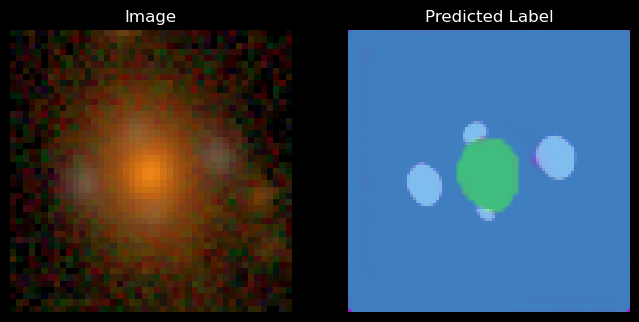

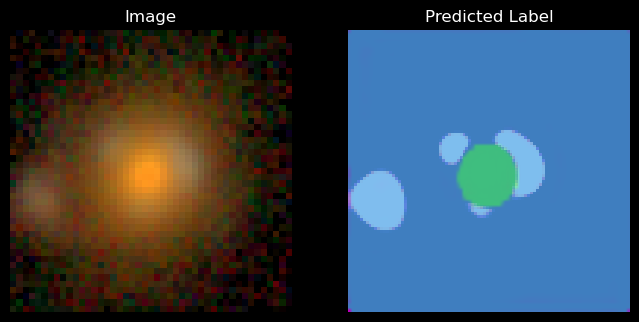

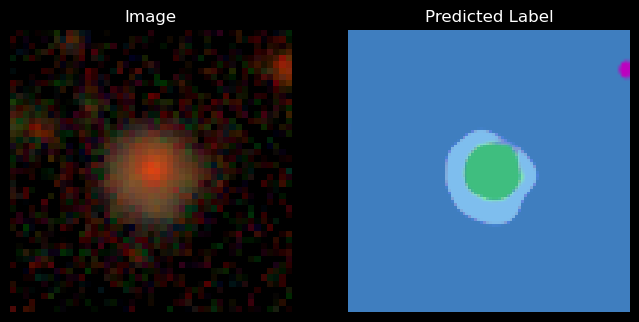

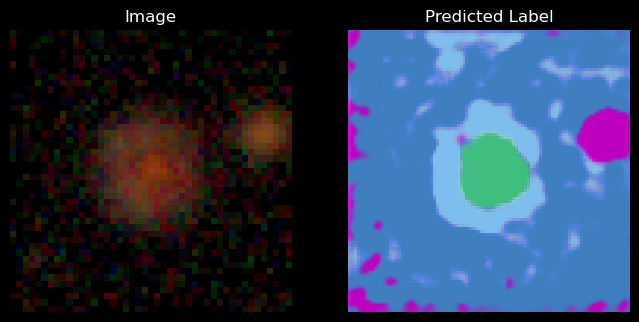

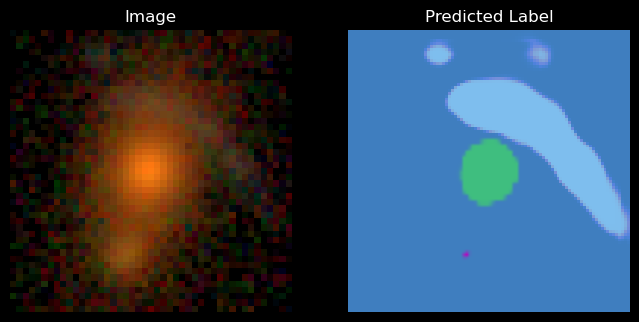

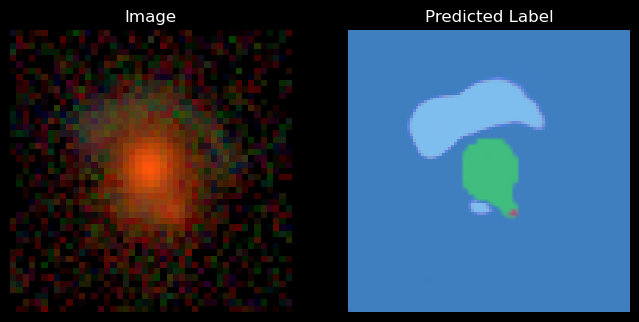

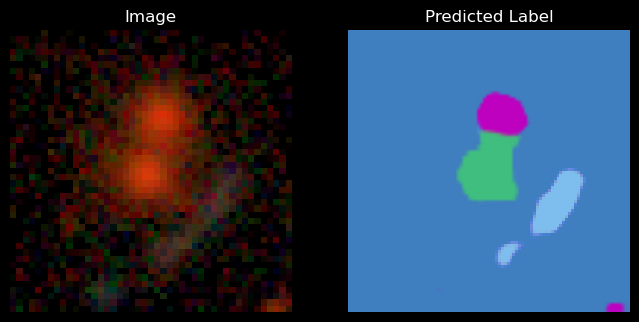

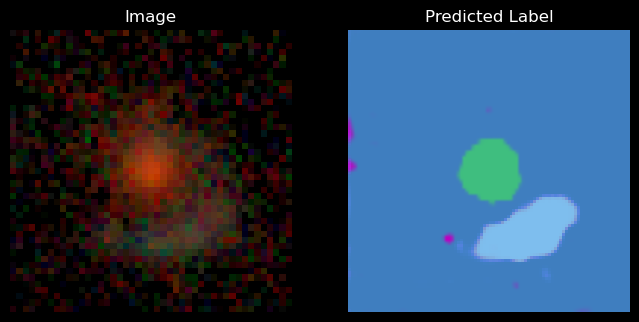

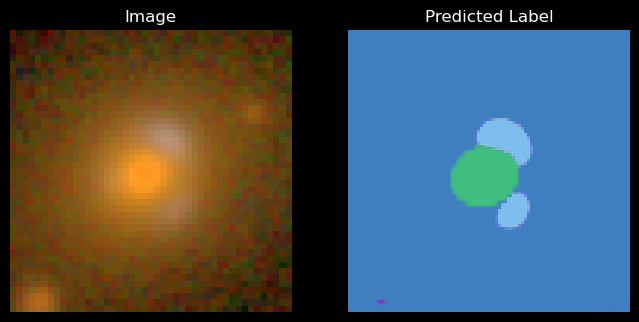

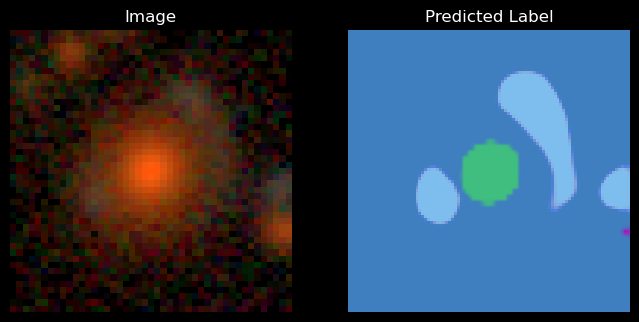

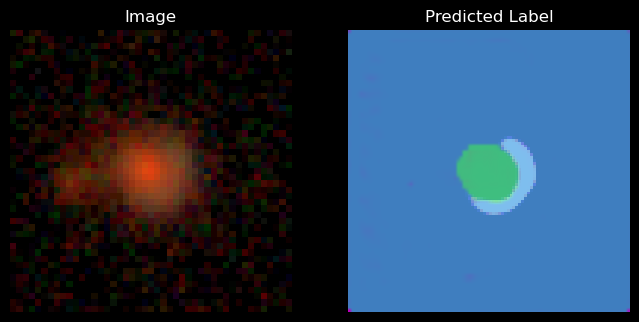

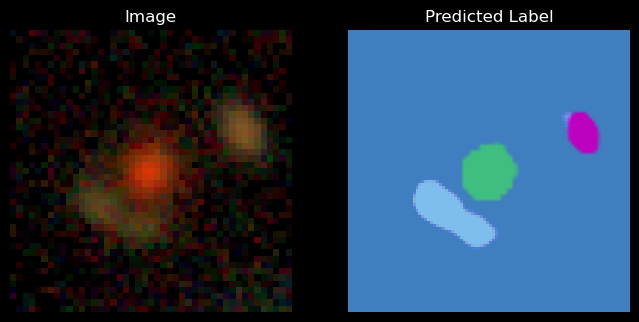

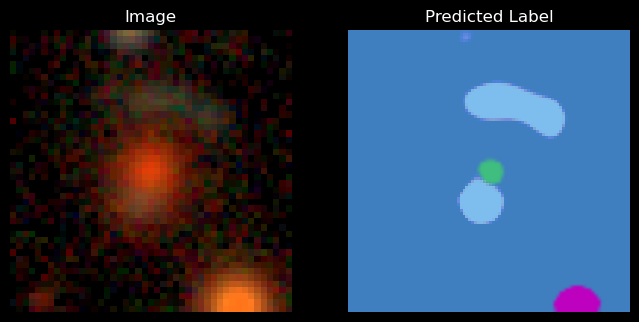

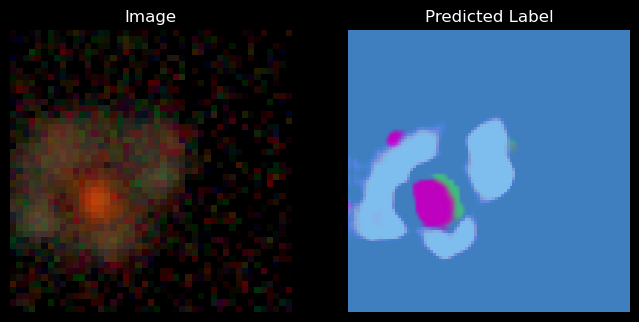

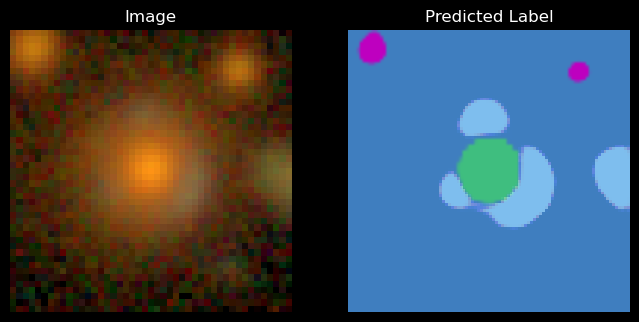

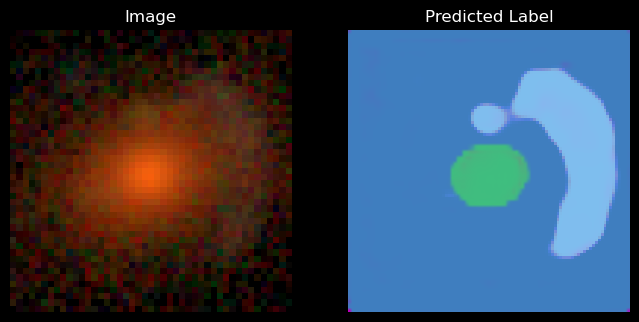

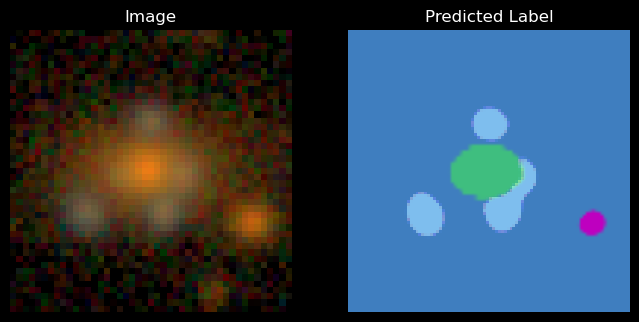

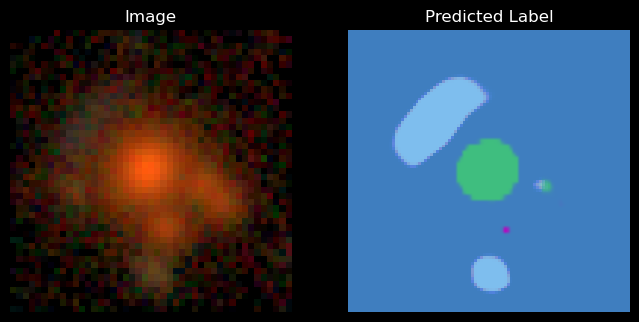

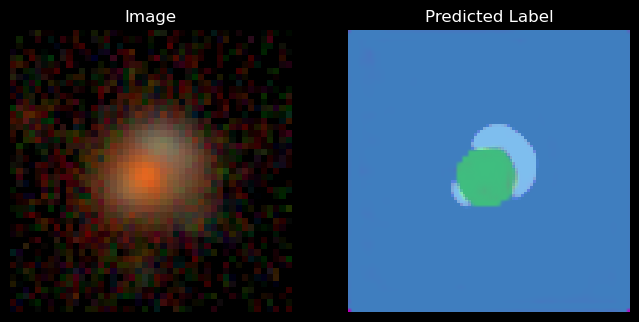

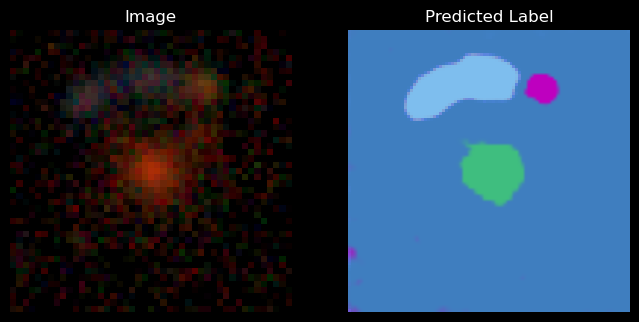

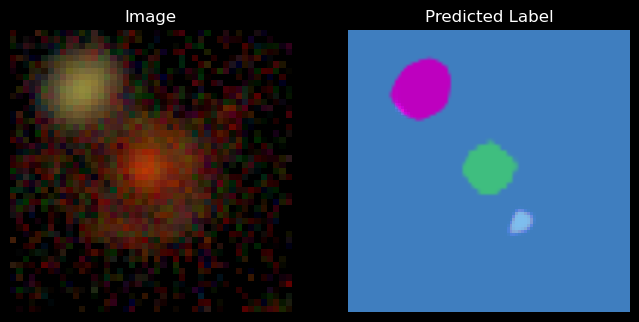

In [36]:
testing_analysis(0.5, test_loader)
plt.close('all')